In [8]:
from pckgs.helper import PnlCallback
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sb
from pckgs.models import get_model_price, train_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from pckgs.evaluator import Evaluator
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Dense, Reshape, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read
# df = pd.read_csv('./datasets/bitcoin_position_day.csv', header=0, parse_dates=['Timestamp'], index_col='Timestamp')
df = pd.read_csv('./datasets/bitcoin_position_hour.csv', header=0, parse_dates=['Timestamp'], index_col='Timestamp')

#split
y = df.loc[:, ['down', 'same', 'up']]
x = df.drop(['down', 'same', 'up'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

y_index = y_test.index
x_index = y_train.index

In [3]:
#create labeled y_test to measure pnl, confusion matrix
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)

y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

In [4]:
# df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'])
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_hour.csv', header=0, parse_dates=['Timestamp'])
df_candle.rename(columns={'Timestamp':'date'}, inplace=True)
df_candle.set_index('date', inplace=True)
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
# align dates
df_candle_y = df_candle.reindex(y_index)
df_candle_x = df_candle.reindex(x_index)

In [5]:
print(y_train.value_counts())

down  same  up
0     0     1     17841
1     0     0     16614
0     1     0       569
dtype: int64


In [11]:
model = get_model_price()

In [12]:
model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_price.h5', 3, 1 )

Epoch 1/3
1088/1095 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.5040

<AxesSubplot:>

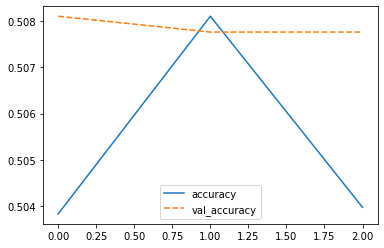

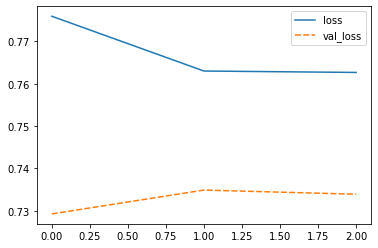

In [13]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)

In [ ]:
#create labeled y_pred for pnl, confusion matrix
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

Evaluator.evaluate(y_pred_labeled, y_test_labeled, df_candle_y)

In [ ]:
y_predt = model.predict(x_train)
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

Evaluator.evaluate(y_predt_labeled, y_train_labeled, df_candle_x)

In [ ]:
print(classification_report(y_test_labeled, y_pred_labeled))

In [ ]:
#test
temp =  {'train_accuracy':[], 'train_f1':[], 'test_accuracy':[], 'test_f1':[]}

for i in range(10):
    model = get_model_price()
    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
    mc = ModelCheckpoint('model_price.h5',verbose=0, save_best_only=True)    #MLP

    history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32
                        ,epochs=300, verbose=0, callbacks=[es, mc])#, shuffle=False)
    model = load_model('model_price.h5')
    y_pred = model.predict(x_test)
    y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
    y_pred_labeled = y_pred_labeled.idxmax(axis=1)
    y_predt = model.predict(x_train)
    y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
    y_predt_labeled = y_predt_labeled.idxmax(axis=1)
    results_test = classification_report(y_test_labeled, y_pred_labeled, output_dict=True)
    temp['test_accuracy'].append(results_test['accuracy'])
    temp['test_f1'].append(results_test['weighted avg']['f1-score'])
    results_test = classification_report(y_train_labeled, y_predt_labeled, output_dict=True)
    temp['train_accuracy'].append(results_test['accuracy'])
    temp['train_f1'].append(results_test['weighted avg']['f1-score'])
temp

In [ ]:
import statistics

print(statistics.mean(temp['train_f1']))
print(statistics.mean(temp['test_f1']))
print(statistics.mean(temp['train_accuracy']))
print(statistics.mean(temp['test_accuracy']))